# A/B Testing from Scratch: Multi-armed Bandits

In [148]:
import numpy as np
import pandas as pd

#widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

#plots
import matplotlib.pyplot as plt
from plotnine import *

#stats
import scipy as sp
import statsmodels as sm

In [149]:
class Arm:
    def __init__(self, true_p):
        self.true_p = true_p
        self.reset()
    def reset(self):
        self.impressions = 1
        self.actions = 1
    def get_state(self):
        return self.impressions,self.actions
    def get_rate(self):
        return self.actions / self.impressions
    def pull(self):
        self.impressions+=1
        res = 1 if np.random.random() < self.true_p else 0
        self.actions+=res
        return res
a = Arm(0.1)
for i in range(100): a.pull()
a.get_state()

(101, 12)

In [150]:
class MusketeerEnv:
    def __init__(self, true_ps, avg_impressions):
        self.true_ps = true_ps
        self.avg_impressions = avg_impressions
        self.nb_arms = len(true_ps)
        self.reset()
    def reset(self):
        self.t = -1
        self.ds=[]
        self.arms = [Arm(p) for p in self.true_ps]
        return self.get_state()
    def get_state(self):
        return [self.arms[i].get_state() for i in range(self.nb_arms)]
    def get_impressions(self):
        return int(np.random.triangular(self.avg_impressions/2,
                                    self.avg_impressions,
                                    self.avg_impressions*1.5))
    def step(self, ps):
        self.t+=1
        impressions = self.get_impressions()
        for i in np.random.choice(a=self.nb_arms,size=impressions,p=ps):
            self.arms[i].pull()
        self.record()
        return self.get_state()
    def record(self):
        d = {'t':self.t,'max_rate':0,'opt_impressions':0}
        for i in range(self.nb_arms):
            d[f'impressions_{i}'],d[f'actions_{i}'] = self.arms[i].get_state()
            d[f'rate_{i}'] = self.arms[i].get_rate()
            if d[f'rate_{i}'] > d['max_rate']: 
                d['max_rate'] = d[f'rate_{i}']
                d['opt_impressions'] = d[f'impressions_{i}']
        d['total_impressions'] = sum([self.arms[i].impressions for i in range(self.nb_arms)])
        d['opt_impressions_rate'] = d['opt_impressions'] / d['total_impressions']
        d['total_actions'] = sum([self.arms[i].actions for i in range(self.nb_arms)])
        d['total_rate'] = d['total_actions'] / d['total_impressions']
#         d['regret_rate'] = d['max_rate'] - d['total_rate']
#         d['regret'] = d['regret_rate'] * d['total_impressions']
        self.ds.append(d)
    def show_df(self):
        df = pd.DataFrame(self.ds)
        cols = ['t'] + [f'rate_{i}' for i in range(self.nb_arms)]+ \
               [f'impressions_{i}' for i in range(self.nb_arms)]+ \
               [f'actions_{i}' for i in range(self.nb_arms)]+ \
               ['total_impressions','total_actions','total_rate']+ \
               ['opt_impressions','opt_impressions_rate']
#                ['regret_rate','regret']+ \
        df = df[cols]
        return df
env = MusketeerEnv(true_ps = [0.1,0.12,0.13], avg_impressions=500)

In [151]:
for i in range(10):
    print(env.step([0.7,0.2,0.1]))

[(331, 40), (107, 11), (39, 7)]
[(677, 70), (197, 21), (96, 12)]
[(969, 99), (271, 29), (138, 16)]
[(1430, 147), (413, 49), (218, 24)]
[(1674, 168), (479, 57), (251, 28)]
[(2086, 207), (587, 72), (302, 37)]
[(2318, 232), (665, 80), (327, 44)]
[(2737, 267), (806, 93), (381, 49)]
[(3138, 313), (915, 104), (434, 54)]
[(3551, 346), (1045, 115), (490, 66)]


In [152]:
env.show_df()

,t,rate_0,rate_1,rate_2,impressions_0,impressions_1,impressions_2,actions_0,actions_1,actions_2,total_impressions,total_actions,total_rate,opt_impressions,opt_impressions_rate
0,0,0.120846,0.102804,0.179487,331,107,39,40,11,7,477,58,0.121593,39,0.081761
1,1,0.103397,0.106599,0.125000,677,197,96,70,21,12,970,103,0.106186,96,0.098969
2,2,0.102167,0.107011,0.115942,969,271,138,99,29,16,1378,144,0.104499,138,0.100145
3,3,0.102797,0.118644,0.110092,1430,413,218,147,49,24,2061,220,0.106744,413,0.200388
4,4,0.100358,0.118998,0.111554,1674,479,251,168,57,28,2404,253,0.105241,479,0.199251
5,5,0.099233,0.122658,0.122517,2086,587,302,207,72,37,2975,316,0.106218,587,0.197311
6,6,0.100086,0.120301,0.134557,2318,665,327,232,80,44,3310,356,0.107553,327,0.098792
7,7,0.097552,0.115385,0.128609,2737,806,381,267,93,49,3924,409,0.104230,381,0.097095
8,8,0.099745,0.113661,0.124424,3138,915,434,313,104,54,4487,471,0.104970,434,0.096724
9,9,0.097437,0.110048,0.134694,3551,1045,490,346,115,66,5086,527,0.103618,490,0.096343


In [194]:
class Agent:
    def __init__(self, env):
        self.env = env
    def equal_weights(self):
        res = np.array([1/self.env.nb_arms for i in range(self.env.nb_arms)])
        return res
    def randomize(self):
        res = np.random.rand(self.env.nb_arms)
        res /= res.sum()
        return res
    def eps_greedy(self, eps = 0.3):
        res = np.array([eps/self.env.nb_arms for i in range(self.env.nb_arms)])
        best_idx = np.argmax([self.env.arms[i].get_rate() for i in range(self.env.nb_arms)])
        res[best_idx] += 1-eps
        return res
    def softmax(self,tau=0.05):
        sum_exp = sum([np.exp(env.arms[i].get_rate()/tau) for i in range(self.env.nb_arms)])
        res = np.array([np.exp(env.arms[i].get_rate()/tau) / sum_exp for i in range(self.env.nb_arms)])
        return res
    def ucb(self):
        res = [(self.env.arms[i].get_rate() + np.sqrt(2*np.log(self.env.t)/self.env.arms[i].impressions)) for i in range(self.env.nb_arms)]
        res = np.array(res)
        res /= res.sum()
        return res
    def thompson(self):
        res = [np.random.beta(self.env.arms[i].actions,self.env.arms[i].impressions-self.env.arms[i].actions) for i in range(self.env.nb_arms)]
        res = np.array(res)
        res /= res.sum()
        return res

a = Agent(env)
a.equal_weights(), a.randomize(), a.eps_greedy(), a.softmax(), a.ucb(), a.thompson()

(array([0.33333333, 0.33333333, 0.33333333]),
 array([0.46980922, 0.45481668, 0.0753741 ]),
 array([0.1, 0.1, 0.8]),
 array([0.28174879, 0.34762404, 0.37062717]),
 array([0.32104034, 0.34990071, 0.32905894]),
 array([0.30956341, 0.33949556, 0.35094102]))

In [195]:
[env.arms[i].get_rate() for i in range(env.nb_arms)]

[0.09953142672483438, 0.11003671233975966, 0.113240466365726]

In [218]:
env = MusketeerEnv(true_ps = [0.1,0.112,0.113], avg_impressions=100)
for i in range(5000):
    action = a.softmax()
    env.step(action)
df = env.show_df()

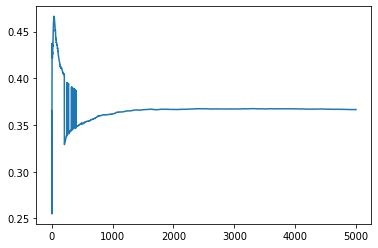

In [219]:
plt.plot(df.opt_impressions_rate)

In [203]:
df.tail()

,t,rate_0,rate_1,rate_2,impressions_0,impressions_1,impressions_2,actions_0,actions_1,actions_2,total_impressions,total_actions,total_rate,opt_impressions,opt_impressions_rate
995,995,0.099670,0.113478,0.112062,152433,168139,173592,15193,19080,19453,494164,53726,0.108721,168139,0.340249
996,996,0.099681,0.113458,0.112033,152566,168274,173725,15208,19092,19463,494565,53763,0.108708,168274,0.340246
997,997,0.099699,0.113455,0.112063,152720,168410,173902,15226,19107,19488,495032,53821,0.108722,168410,0.340200
998,998,0.099687,0.113433,0.112064,152888,168575,174079,15241,19122,19508,495542,53871,0.108711,168575,0.340183
999,999,0.099713,0.113437,0.112063,153049,168719,174242,15261,19139,19526,496010,53926,0.108720,168719,0.340152
